### Data Preparation
(read + add technical indicators + convert close prise to log returns)

In [1]:
import ta
import pandas as pd
import numpy as np

In [2]:
%%capture

data = pd.read_csv('data/stocks_s&p500/NFLX_data.csv').rename(columns={"date": "Date", "open": "Open", "high": "High",
                                                                    "low": "Low", "close": "Close", "volume": "Volume"}).drop(['Name'], axis=1)
data['LogRet'] = np.log(data['Close']).diff()
data = ta.add_all_ta_features(
    data, open="Open", high="High", low="Low", close="LogRet", volume="Volume")
data_array = data[['LogRet', 'trend_macd', 'momentum_stoch_rsi', 'volatility_bbl']].dropna().to_numpy()

print prices plot

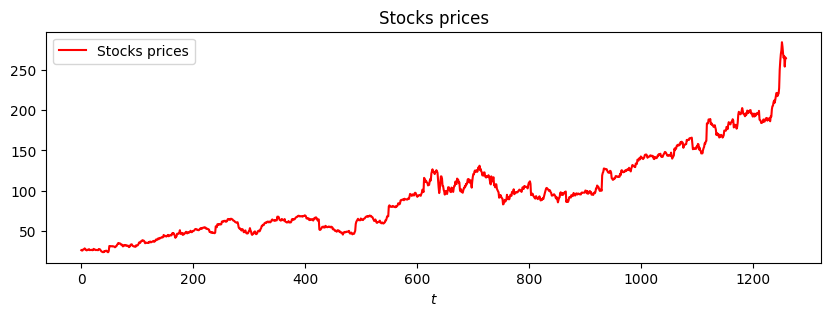

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.title("Stocks prices")
plt.xlabel("$t$")

plt.plot(data['Close'], label="Stocks prices", color="red")
plt.legend()
plt.savefig('NetflixStocks.png')

print log returns plot

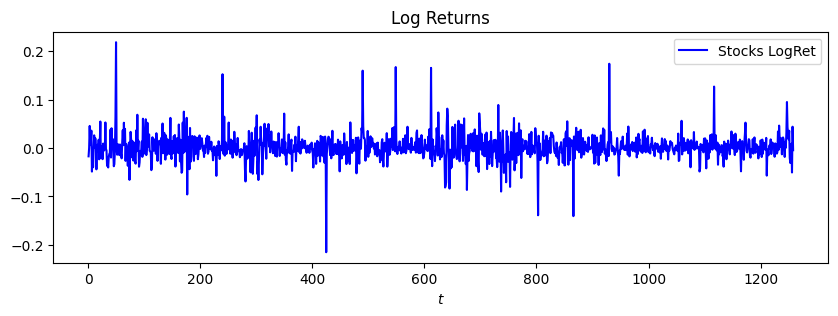

In [4]:
plt.figure(figsize=(10, 3))
plt.title("Log Returns")
plt.xlabel("$t$")

plt.plot(data['LogRet'], label="Stocks LogRet", color="blue")
plt.legend()
plt.savefig('NetflixLogReturns.png')

In [5]:
import statsmodels.api as sm

logrets = data['LogRet'].dropna().to_numpy()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(logrets)[1])

Dickey-Fuller test: p=0.000000


In [16]:
def error_variance(y_true, y_false):
    error = y_true - y_false
    var = np.var(error)
    return var

### Reservoir model

При инициализации объекта класса ESNPredictions можно выбрать: размер окна, используемого для генерации предсказаний(window_size), количество шагов предсказания(forecast_size), размер тестовой выборки(test_size) \
При вызове функции get_predictions можно указать параметр отвечающий за оптимизацию гиперпараметров модели(opt)

In [6]:
%%capture

from models.esn import ESNPredictions

esn_preds_simple = ESNPredictions(data_array, window_size=50, forecast_size=10, test_size=0.1, model_type='simple')
Y_pred_simple = esn_preds_simple .get_predictions(opt=False)
Y_test_simple = esn_preds_simple .Y_test[:, 0][:len(Y_pred_simple)]

In [7]:
%%capture

esn_preds_deep = ESNPredictions(data_array, window_size=50, forecast_size=10, test_size=0.1, model_type='deep')
Y_pred_deep = esn_preds_deep.get_predictions(opt=False)
Y_test_deep = esn_preds_deep.Y_test[:, 0][:len(Y_pred_deep)]

In [8]:
%%capture

esn_preds_hier = ESNPredictions(data_array, window_size=50, forecast_size=10, test_size=0.1, model_type='hierarchical')
Y_pred_hier = esn_preds_hier.get_predictions(opt=False)
Y_test_hier = esn_preds_hier.Y_test[:, 0][:len(Y_pred_hier)]

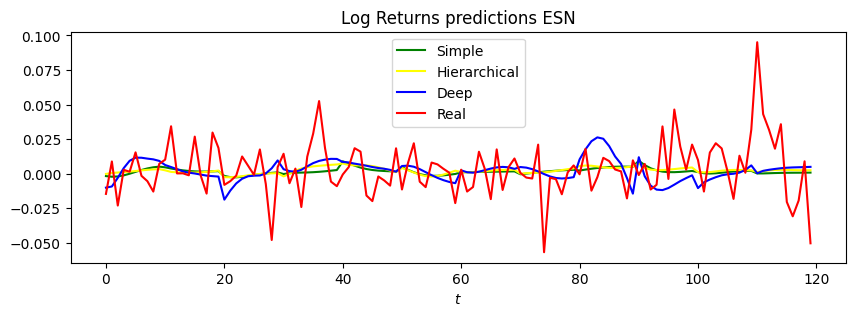

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.title("Log Returns predictions ESN")
plt.xlabel("$t$")
plt.plot(Y_pred_simple, label="Simple", color="green")
plt.plot(Y_pred_hier, label="Hierarchical", color="yellow")
plt.plot(Y_pred_deep, label="Deep", color="blue")
plt.plot(Y_test_simple, label="Real", color="red")
plt.legend()
plt.savefig('ESNNetflixStocksReturnPredictions.png')

In [10]:
from sklearn import metrics

mae_simple = metrics.mean_absolute_error(Y_test_simple, Y_pred_simple[:len(Y_test_simple)])
mae_deep = metrics.mean_absolute_error(Y_test_deep, Y_pred_deep[:len(Y_test_deep)])
mae_hier = metrics.mean_absolute_error(Y_test_hier, Y_pred_hier[:len(Y_test_hier)])
print('MAE для simple ESN модели:', mae_simple)
print('MAE для deep ESN модели:', mae_deep)
print('MAE для hier ESN модели:', mae_hier)

MAE для simple ESN модели: 0.014143662276634083
MAE для deep ESN модели: 0.015286455072354583
MAE для hier ESN модели: 0.013971094843331956


In [11]:
mse_simple = metrics.mean_squared_error(Y_test_simple, Y_pred_simple[:len(Y_test_simple)])
mse_deep = metrics.mean_squared_error(Y_test_deep, Y_pred_deep[:len(Y_test_deep)])
mse_hier = metrics.mean_squared_error(Y_test_hier, Y_pred_hier[:len(Y_test_hier)])
print('MSE для simple ESN модели:', mse_simple)
print('MSE для deep ESN модели:', mse_deep)
print('MSE для hier ESN модели:', mse_hier)

MSE для simple ESN модели: 0.00039396705627552694
MSE для deep ESN модели: 0.0004385647100915153
MSE для hier ESN модели: 0.00038694543756528286


In [17]:
ervar_simple = error_variance(Y_test_simple, Y_pred_simple[:len(Y_test_simple)])
ervar_deep = error_variance(Y_test_deep, Y_pred_deep[:len(Y_test_deep)])
ervar_hier = error_variance(Y_test_hier, Y_pred_hier[:len(Y_test_hier)])
print('MSE для simple ESN модели:', ervar_simple)
print('MSE для deep ESN модели:', ervar_deep)
print('MSE для hier ESN модели:', ervar_hier)

MSE для simple ESN модели: 0.0003908451731300525
MSE для deep ESN модели: 0.0004370987379892048
MSE для hier ESN модели: 0.0003857827936723332


### Arima
При инициализации объекта класса Arimaredictions можно выбрать: количество шагов предсказания(forecast_size), размер тестовой выборки(test_size) \
При вызове функции get_predictions можно указать параметр отвечающий за оптимизацию гиперпараметров модели(opt)

In [12]:
%%capture
from models.arima import ArimaPredictions

arima = ArimaPredictions(data_array, forecast_size=10, test_size=0.1)
Y_pred_arima = arima.get_predictions(opt=False)
Y_test_arima = arima.Y_test[:len(Y_pred_arima)]

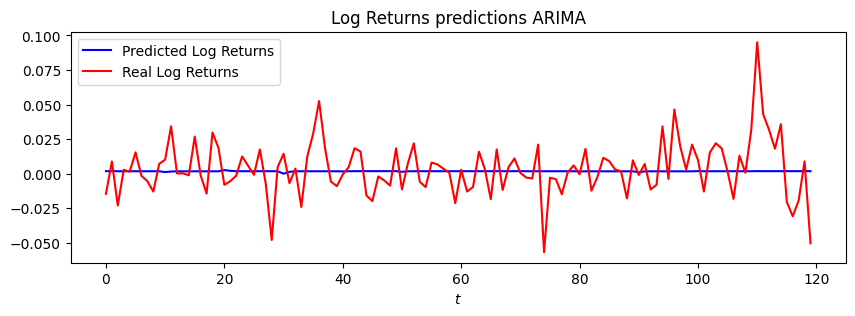

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.title("Log Returns predictions ARIMA")
plt.xlabel("$t$")
#plt.plot(Y_train, label="Predicted stocks", color="red")
plt.plot(Y_pred_arima, label="Predicted Log Returns", color="blue")
plt.plot(Y_test_arima, label="Real Log Returns", color="red")
plt.legend()
plt.savefig('ArimaNetflixStocksReturnPredictions.png')

In [14]:
mae = metrics.mean_absolute_error(Y_test_arima, Y_pred_arima)
print('MAE для Arima модели:', mae)

MAE для Arima модели: 0.013968513974034027


In [20]:
mse = metrics.mean_squared_error(Y_test_arima, Y_pred_arima)
print('MSE для Arima модели:', mse)

MSE для Arima модели: 0.00038892035307535173


### LSTM

In [21]:
%%capture
from models.lstm import LSTMPredictions

lstm = LSTMPredictions(data_array, window_size=50, forecast_size=10, test_size=0.1)
Y_pred_lstm = lstm.get_predictions(opt=False)
Y_test_lstm = lstm.Y_test_one_dim[:len(Y_pred_lstm)]

2024-01-12 00:32:17.218804: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


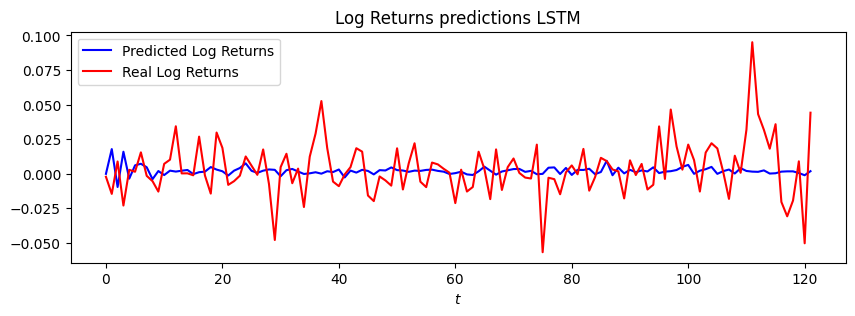

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.title("Log Returns predictions LSTM")
plt.xlabel("$t$")
#plt.plot(Y_train, label="Predicted stocks", color="red")
plt.plot(Y_pred_lstm, label="Predicted Log Returns", color="blue")
plt.plot(Y_test_lstm, label="Real Log Returns", color="red")
plt.legend()
plt.savefig('LSTMNetflixStocksReturnPredictions.png')
#plt.show()

In [23]:
from sklearn import metrics
mae = metrics.mean_absolute_error(Y_test_lstm, Y_pred_lstm)
print('MAE для LSTM модели:', mae)

MAE для LSTM модели: 0.01453223961000743


In [24]:
mse = metrics.mean_squared_error(Y_test_lstm, Y_pred_lstm)
print('MSE для LSTM модели:', mse)

MSE для LSTM модели: 0.0004119519062834115


### GRU

In [28]:
%%capture
from models.gru import GRUPredictions

gru = GRUPredictions(data_array, window_size=100, forecast_size=10, test_size=0.1)
Y_pred_gru = gru.get_predictions(opt=False)
Y_test_gru = gru.Y_test_one_dim[:len(Y_pred_gru)]

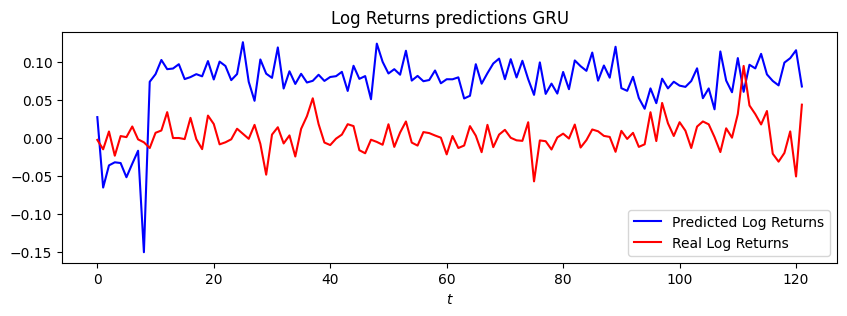

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.title("Log Returns predictions GRU")
plt.xlabel("$t$")

plt.plot(Y_pred_gru, label="Predicted Log Returns", color="blue")
plt.plot(Y_test_gru, label="Real Log Returns", color="red")
plt.legend()
plt.savefig('GRUNetflixStocksReturnPredictions.png')

In [30]:
from sklearn import metrics
mae = metrics.mean_absolute_error(Y_test_gru, Y_pred_gru)
print('MAE для GRU модели:', mae)

MAE для GRU модели: 0.07638738632247112


In [31]:
mse = metrics.mean_squared_error(Y_test_gru, Y_pred_gru)
print('MSE для GRU модели:', mse)

MSE для GRU модели: 0.00662415220476261


### Stocks

In [33]:
def convert_to_price(Y_real, Y_pred, forecast_size = 10):
    Y_real = Y_real[::forecast_size]
    #print(Y_real)
    Y_pred_cut = [Y_pred[j:j+forecast_size] for j in range(0, len(Y_pred), forecast_size)]
    #print(Y_pred_cut)
    Y_price_pred = []
    for i in range(len(Y_real)):
        predicted = (np.exp(np.cumsum(Y_pred_cut[i]))) * Y_real[i]
        #print(predicted)
        Y_price_pred.extend(predicted)
    return Y_price_pred

In [34]:
Y_real = data['Close'][-len(Y_pred_simple):].values
Y_price_simple=convert_to_price(Y_real, Y_pred_simple)
Y_price_deep=convert_to_price(Y_real, Y_pred_deep)
Y_price_hier=convert_to_price(Y_real, Y_pred_hier)
Y_price_lstm=convert_to_price(Y_real, Y_pred_lstm[:len(Y_real)])
Y_price_gru=convert_to_price(Y_real, Y_pred_gru[:len(Y_real)])
Y_price_arima=convert_to_price(Y_real, Y_pred_arima[:len(Y_real)])

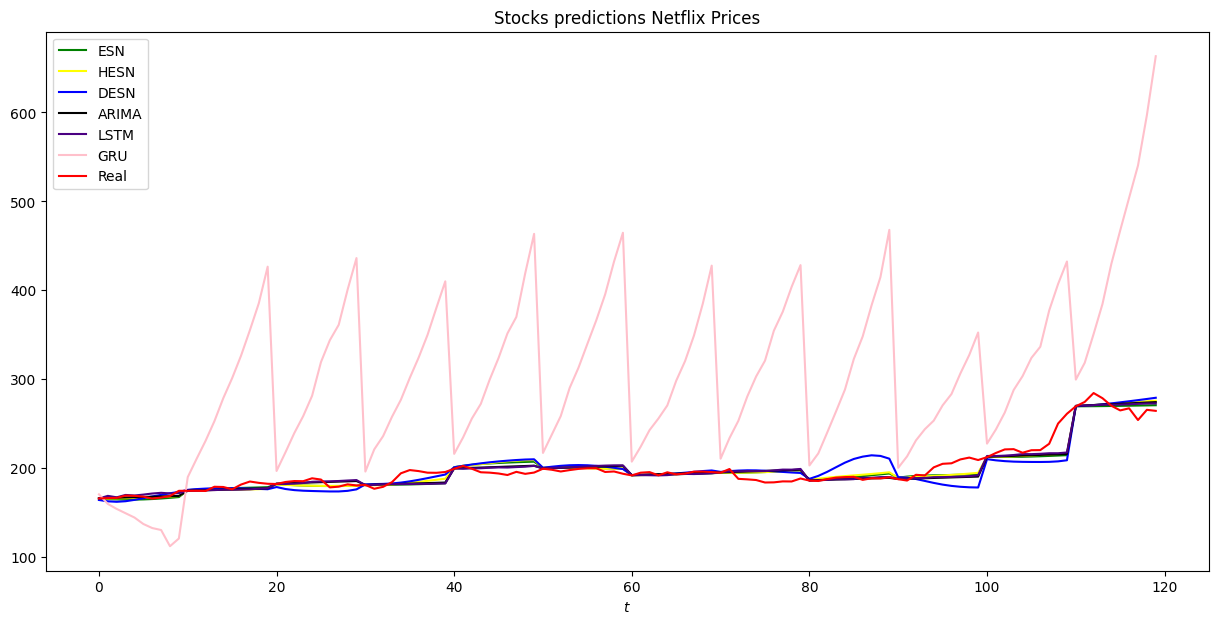

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.title("Stocks predictions Netflix Prices")
plt.xlabel("$t$")
plt.plot(Y_price_simple, label="ESN", color="green")
plt.plot(Y_price_hier, label="HESN", color="yellow")
plt.plot(Y_price_deep, label="DESN", color="blue")
plt.plot(Y_price_arima, label="ARIMA", color="black")
plt.plot(Y_price_lstm, label="LSTM", color="indigo")
plt.plot(Y_price_gru, label="GRU", color="pink")
plt.plot(Y_real, label="Real", color="red")
plt.legend()
#plt.show()
plt.savefig('NetflixStocksPredictions.png')

In [36]:
mae_simple = metrics.mean_absolute_error(Y_real, Y_price_simple)
mae_deep = metrics.mean_absolute_error(Y_real, Y_price_deep)
mae_hier = metrics.mean_absolute_error(Y_real, Y_price_hier)
mae_arima = metrics.mean_absolute_error(Y_real, Y_price_arima)
mae_lstm = metrics.mean_absolute_error(Y_real, Y_price_lstm)
mae_gru = metrics.mean_absolute_error(Y_real, Y_price_gru)
print('MAE для simple ESN модели:', mae_simple)
print('MAE для deep ESN модели:', mae_deep)
print('MAE для hier ESN модели:', mae_hier)
print('MAE для arima модели:', mae_arima)
print('MAE для lstm модели:', mae_lstm)
print('MAE для gru модели:', mae_gru)

MAE для simple ESN модели: 5.89820240095295
MAE для deep ESN модели: 8.932055692465115
MAE для hier ESN модели: 5.907177646261988
MAE для arima модели: 5.731325244005815
MAE для lstm модели: 5.795581720987957
MAE для gru модели: 111.37146761830648


In [38]:
mse_simple = metrics.mean_squared_error(Y_real, Y_price_simple)
mse_deep = metrics.mean_squared_error(Y_real, Y_price_deep)
mse_hier = metrics.mean_squared_error(Y_real, Y_price_hier)
mse_arima = metrics.mean_squared_error(Y_real, Y_price_arima)
mse_lstm = metrics.mean_squared_error(Y_real, Y_price_lstm)
mse_gru = metrics.mean_squared_error(Y_real, Y_price_gru)
print('MSE для simple ESN модели:', mse_simple)
print('MSE для deep ESN модели:', mse_deep)
print('MSE для hier ESN модели:', mse_hier)
print('MSE для arima модели:', mse_arima)
print('MSE для lstm модели:', mse_lstm)
print('MSE для gru модели:', mse_gru)

MSE для simple ESN модели: 79.66996932044935
MSE для deep ESN модели: 159.09955031001167
MSE для hier ESN модели: 77.35043572835671
MSE для arima модели: 77.90648807976004
MSE для lstm модели: 75.35923298142112
MSE для gru модели: 19013.62374456087
